In [1]:
import yfinance as yf
import pandas as pd

from fbprophet import Prophet

from fbprophet.plot import plot_plotly
import plotly.offline as py

from fbprophet.plot import add_changepoints_to_plot

## Get data from yfinance

In [2]:
"""
period : str
    Valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
interval : str (Intraday data cannot extend last 60 days)
    Valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
start: str(YYYY-MM-DD) or _datetime
end: str (YYYY-MM-DD) or _datetime
"""

def get_historical_yfinance(tickers):
    # Select requested tickers
    tickers = yf.Tickers(" ".join(tickers.keys()))
    # Return dataframe for all tickers
    return tickers.history(period="1mo", interval="1d", start=None, end=None, actions=True, rounding=True)

my_tickers = {'ATVI': 'Activision',
              'ADS': 'Adidas',
              'GOOG': 'Alphabet',
              'MSFT': 'Microsoft',
              'AMZN': 'Amazon.com',
              'TEF': 'Telefonica',
              'CHFS': 'CHF_Solutions',
              'ASTC': 'Astrotech'
          }

hist = get_historical_yfinance(tickers=my_tickers)

[*********************100%***********************]  8 of 8 completed


In [3]:
def set_change_label(x):
    if x > 0:
        return 1
    else:
        return 0

def add_historical_extra_info(df):
    for ticker in my_tickers.keys():
        df['Change', ticker] = df['Close', ticker].diff()
        df['Change_Percent', ticker] = df['Close', ticker].div(df['Close', ticker].shift(1))*100-100
        df['Change_Label', ticker] = df['Change', ticker].apply(set_change_label)
    return df

hist = add_historical_extra_info(df=hist)
display(hist.tail())

def plot_one_ticker(df, stock_label):
    hist_one = hist.iloc[:, hist.columns.get_level_values(1)==stock_label]
    #Delete level 1 column labels
    hist_one = hist_one.T.reset_index(level=1, drop=True).T
    display(hist_one.tail())
    display(hist_one['Change_Percent'].plot(figsize=(15,6)))
    #Extra info
    print("Change Mean:", hist_one['Change'].mean())
    print("Change Sum:", hist_one['Change'].sum())
    print("Change Percent Mean:", hist_one['Change_Percent'].mean())
    print("Change Label:", hist_one['Change_Label'].mean())
    
#plot_one_ticker(df=hist, stock_label='TEF')

Close                                                     \
              ADS     AMZN  ASTC   ATVI  CHFS     GOOG    MSFT   TEF   
Date                                                                   
2020-03-23  31.02  1902.83  1.11  56.47  0.32  1056.62  135.98  4.57   
2020-03-24  42.01  1940.10  1.12  54.43  0.33  1134.46  148.34  4.82   
2020-03-25  38.51  1885.84  4.05  52.87  0.37  1102.49  146.92  4.75   
2020-03-26  37.55  1955.49  3.47  57.72  0.37  1161.75  156.11  4.72   
2020-03-27  36.47  1900.10  3.63  56.96  0.47  1110.71  149.70  4.56   

           Dividends       ... Change_Label Change Change_Percent  \
                 ADS AMZN  ...         AMZN    TEF            TEF   
Date                       ...                                      
2020-03-23         0    0  ...            1   0.01       0.219298   
2020-03-24         0    0  ...            1   0.25       5.470460   
2020-03-25         0    0  ...            0  -0.07      -1.452282   
2020-03-26         0    0  ...            1  -0.03      -0.631579   
2020-03-27         0    0  ...            0  -0.16      -3.389831   

           Change_Label Change Change_Percent Change_Label Change  \
                    TEF   CHFS           CHFS         CHFS   ASTC   
Date                                                                
2020-03-23            1   0.00       0.000000            0   0.02   
2020-03-24            1   0.01       3.125000            1   0.01   
2020-03-25            0   0.04      12.121212            1   2.93   
2020-03-26            0   0.00       0.000000            0  -0.58   
2020-03-27            0   0.10      27.027027            1   0.16   

           Change_Percent Change_Label  
                     ASTC         ASTC  
Date                                    
2020-03-23       1.834862            1  
2020-03-24       0.900901            1  
2020-03-25     261.607143            1  
2020-03-26     -14.320988            0  
2020-03-27       4.610951            1  

[5 rows x 80 columns]

## Prepare dataset

In [4]:
def prepare_dataset(df, ticker, column):
    # column = [Close, Dividends, High, Low, Open, Stock Splits, Volume, Change, Change_Percent, Change_Label]
    return pd.DataFrame({'ds': list(hist.index), 
                         'y': list(hist[column, ticker])
                        })

hist_one_prophet = prepare_dataset(df=hist, ticker='TEF', column='Change_Percent')

hist_one_prophet.tail()

,ds,y
15,2020-03-23,0.219298
16,2020-03-24,5.470460
17,2020-03-25,-1.452282
18,2020-03-26,-0.631579
19,2020-03-27,-3.389831


## Prophet

In [5]:
def make_prophet_model(df):
    model = Prophet(growth='linear', ## growth = ['linear', 'logistic'] # Type of regression
                    yearly_seasonality=False,
                    #weekly_seasonality=True,
                    daily_seasonality=False, 
                    seasonality_mode='additive', ## seasonality_mode=['additive', multiplicative']
                    #mcmc_samples=300, ## mcmc_samples = 0 # Uncertainly seasonality
                    #interval_width = 0.8, ## Size of yhat upper and lower
                   )
    #model.add_regressor('reg_volume', mode='additive')
    #model.add_country_holidays(country_name='US')
    model.fit(df)
    return model

model = make_prophet_model(df=hist_one_prophet)

INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


In [6]:
def forecast_prophet(model, days):
    future = model.make_future_dataframe(periods=days, freq='D', include_history=False)
    forecast = model.predict(future)
    forecast = forecast[forecast.ds.dt.dayofweek<=4] # Take out Sat and Sun
    return forecast
    
forecast = forecast_prophet(model=model, days=7)

display(forecast)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2,2020-03-30,2.967357,-10.658071,2.472739,2.967357,2.967357,-7.063195,-7.063195,-7.063195,-7.063195,-7.063195,-7.063195,0.0,0.0,0.0,-4.095837
3,2020-03-31,3.155170,2.031481,15.715674,3.155170,3.155170,5.644277,5.644277,5.644277,5.644277,5.644277,5.644277,0.0,0.0,0.0,8.799447
4,2020-04-01,3.342983,-5.728791,9.198965,3.342983,3.342984,-1.706780,-1.706780,-1.706780,-1.706780,-1.706780,-1.706780,0.0,0.0,0.0,1.636204
5,2020-04-02,3.530797,-5.796489,6.984681,3.530797,3.530797,-2.833447,-2.833447,-2.833447,-2.833447,-2.833447,-2.833447,0.0,0.0,0.0,0.697350
6,2020-04-03,3.718610,-5.618567,7.817963,3.718610,3.718610,-2.451622,-2.451622,-2.451622,-2.451622,-2.451622,-2.451622,0.0,0.0,0.0,1.266988


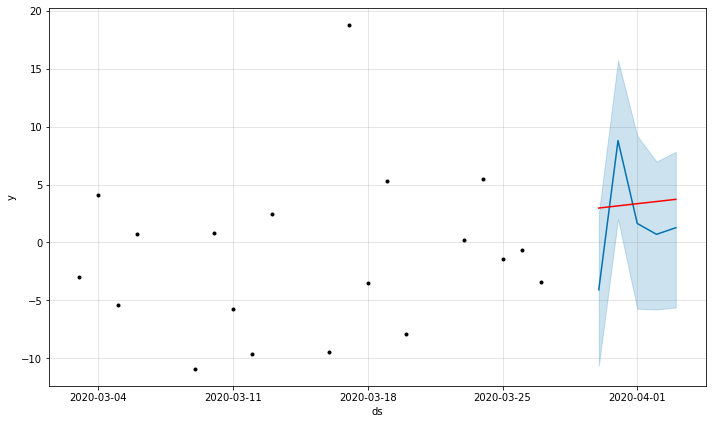

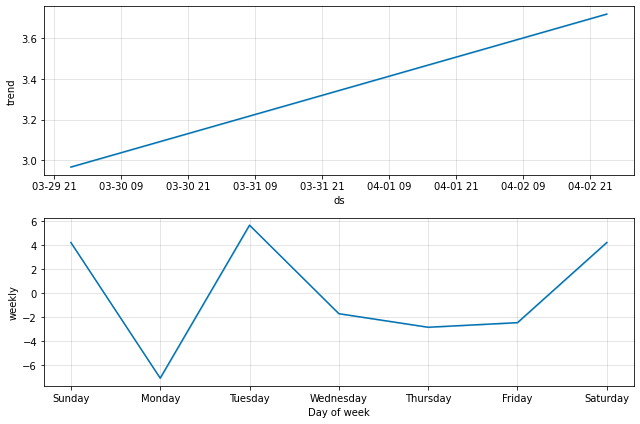

In [7]:
def plot_forecast(model, forecast):
    fig1 = model.plot(forecast) # .tail(days_to_predict-weekend_days)
    a = add_changepoints_to_plot(fig1.gca(), model, forecast) # Add changepoints
    fig2 = model.plot_components(forecast)

plot_forecast(model=model, forecast=forecast)

In [8]:
# py.init_notebook_mode()

# fig = plot_plotly(model, forecast)  # This returns a plotly Figure
# py.iplot(fig)

In [9]:
#help(Prophet.make_future_dataframe)

In [10]:
#help(Prophet)